<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_resnet_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResnetSolver

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=3087aff4efd2b42a3a0eade993f55709a992f24edbc7ae67c14c73f01937edeb
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=e2a4760e98645b61cbfecc2f260d4dbf8289e5837f2ba02d4baed4a34ef7941b
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
# from torchdyn.numerics.solvers import SolverTemplate

In [4]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

In [5]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[:, 0]
    s = x[:, 1]
    p = x[:, 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [6]:
def create_initial_cond(n_training,
                         lower_limit_x,
                         upper_limit_x,
                         lower_limit_s,
                         upper_limit_s,
                         lower_limit_p,
                         upper_limit_p):
    
    x0_train = (
        torch.tensor(lhs(3, n_training), device='cpu') 
    ) 
    x0_train[:,0] = x0_train[:,0] * upper_limit_x + lower_limit_x # biomass (0.2-10.2)
    x0_train[:,1] = x0_train[:,1] * upper_limit_s + lower_limit_s # substrate (0-40)
    x0_train[:,2] = x0_train[:,2] * upper_limit_p + lower_limit_p # product (0-40)
    return x0_train 

In [7]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 10, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 5.5984,  1.7459, 35.1604],
        [10.0896, 12.5094, 28.8365],
        [ 0.6275, 15.3294,  1.1282],
        [ 1.7462, 24.7853,  2.2898],
        [ 1.9415, 22.7795, 29.6224]], dtype=torch.float64)
torch.Size([100, 3])


In [8]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 0.7920, 35.3302, 26.4692],
        [ 2.4684, 11.8598, 32.5543],
        [ 4.4235, 22.5254, 12.9782],
        [ 9.4725,  5.8281, 11.0454],
        [ 6.8641, 28.3738,  3.8358]], dtype=torch.float64)
torch.Size([10, 3])


In [9]:
def create_time_span(start_time, end_time, step_size):
    ε = 1e-10 
    t_span = torch.arange(
        start_time, 
        end_time + ε,
        step_size
    )
    return t_span

In [10]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

In [11]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")

In [12]:
# Function to plot trajectory
def plot_trajectory(n, trajectories):
    if n == 0:
        plt.plot(trajectories[:, n, 0], label='biomass', color="lightgreen")
        plt.plot(trajectories[:, n, 1], label='substrate', color="#F97306")
        plt.plot(trajectories[:, n, 2], label='product', color="#069AF3")
    else: 
        plt.plot(trajectories[:, n, 0], color="lightgreen")
        plt.plot(trajectories[:, n, 1], color="#F97306")
        plt.plot(trajectories[:, n, 2], color="#069AF3")


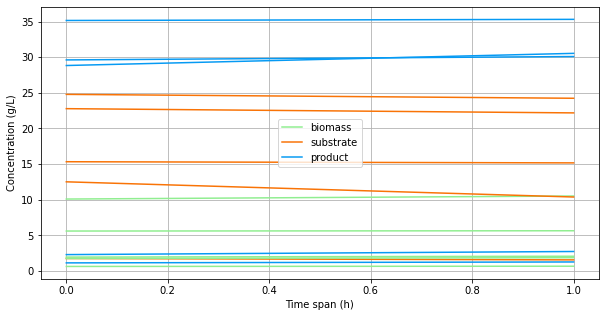

In [13]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

In [14]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

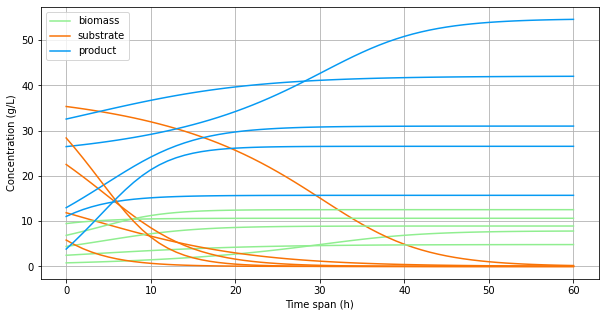

In [15]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

In [16]:
def fnn_model(input_dim, output_dim, hidden_dim, hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [20]:
# Create model
net = fnn_model(3, 3, 32, 8)

In [21]:
# training algorithm
optimizer = Adam(net.parameters()) 

In [22]:
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=ResnetSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    net.eval()
    with torch.inference_mode():

        # 1. Forward pass
        _, x_pred_validate = odeint(
            lambda t, x: net(x), 
            x0_validate, 
            t_span_validate, 
            solver=ResnetSolver()
        )

        # 2. Calculate loss
        loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")


  1%|          | 11/2000 [00:00<00:39, 50.27it/s]

Epoch: 0 | Training loss: 0.7143849583533995 | Validate loss: 4859.672801984476


  3%|▎         | 56/2000 [00:01<00:43, 44.57it/s]

Epoch: 50 | Training loss: 0.06756964551294642 | Validate loss: 44.71763213639657


  5%|▌         | 108/2000 [00:02<00:40, 46.79it/s]

Epoch: 100 | Training loss: 0.0017388053821451644 | Validate loss: 3.3846264825666763


  8%|▊         | 160/2000 [00:03<00:37, 49.38it/s]

Epoch: 150 | Training loss: 0.0005206690961301833 | Validate loss: 1.3548223150152026


 10%|█         | 207/2000 [00:04<00:35, 50.23it/s]

Epoch: 200 | Training loss: 0.00031774688466657696 | Validate loss: 1.0589365624419034


 13%|█▎        | 257/2000 [00:05<00:37, 47.01it/s]

Epoch: 250 | Training loss: 0.00023802435667453895 | Validate loss: 0.6219326035655215


 16%|█▌        | 311/2000 [00:06<00:33, 50.30it/s]

Epoch: 300 | Training loss: 0.00020067060687033937 | Validate loss: 0.4663971867216075


 18%|█▊        | 360/2000 [00:07<00:34, 47.86it/s]

Epoch: 350 | Training loss: 0.00016525885126521348 | Validate loss: 0.27633259785969877


 20%|██        | 408/2000 [00:08<00:31, 50.70it/s]

Epoch: 400 | Training loss: 0.0001648605506973655 | Validate loss: 0.2191447740106345


 23%|██▎       | 461/2000 [00:09<00:30, 50.42it/s]

Epoch: 450 | Training loss: 0.00012866966094912219 | Validate loss: 0.1555667982526124


 25%|██▌       | 509/2000 [00:10<00:29, 50.51it/s]

Epoch: 500 | Training loss: 0.000122490187256066 | Validate loss: 0.14873782331927507


 28%|██▊       | 559/2000 [00:11<00:30, 47.34it/s]

Epoch: 550 | Training loss: 0.00010919137643410399 | Validate loss: 0.10070453752792925


 30%|███       | 610/2000 [00:12<00:27, 50.75it/s]

Epoch: 600 | Training loss: 9.313072512703396e-05 | Validate loss: 0.08215815519877458


 33%|███▎      | 657/2000 [00:13<00:26, 49.79it/s]

Epoch: 650 | Training loss: 8.297924245952687e-05 | Validate loss: 0.06791726568183015


 35%|███▌      | 707/2000 [00:14<00:25, 50.36it/s]

Epoch: 700 | Training loss: 0.00011686455750639355 | Validate loss: 0.08808396952098714


 38%|███▊      | 757/2000 [00:15<00:26, 46.37it/s]

Epoch: 750 | Training loss: 7.057952262329789e-05 | Validate loss: 0.04503060596879851


 40%|████      | 809/2000 [00:16<00:24, 48.32it/s]

Epoch: 800 | Training loss: 6.384244394616376e-05 | Validate loss: 0.04111565902614682


 43%|████▎     | 858/2000 [00:17<00:22, 50.13it/s]

Epoch: 850 | Training loss: 5.8248796600541324e-05 | Validate loss: 0.03885483357024808


 46%|████▌     | 910/2000 [00:18<00:21, 50.78it/s]

Epoch: 900 | Training loss: 0.00010273085498687035 | Validate loss: 0.03874683936929134


 48%|████▊     | 955/2000 [00:19<00:21, 47.71it/s]

Epoch: 950 | Training loss: 5.340719133654212e-05 | Validate loss: 0.03737444961553081


 50%|█████     | 1006/2000 [00:20<00:23, 41.47it/s]

Epoch: 1000 | Training loss: 4.9190110839751055e-05 | Validate loss: 0.03544831845768486


 53%|█████▎    | 1057/2000 [00:21<00:20, 46.10it/s]

Epoch: 1050 | Training loss: 4.573663158195755e-05 | Validate loss: 0.035593273834466456


 55%|█████▌    | 1108/2000 [00:22<00:17, 49.67it/s]

Epoch: 1100 | Training loss: 0.0016697988611864194 | Validate loss: 1.4487266792463598


 58%|█████▊    | 1155/2000 [00:23<00:19, 44.44it/s]

Epoch: 1150 | Training loss: 5.688838785447737e-05 | Validate loss: 0.04388980975041488


 60%|██████    | 1207/2000 [00:24<00:17, 44.89it/s]

Epoch: 1200 | Training loss: 4.134517101481515e-05 | Validate loss: 0.03554457125351677


 63%|██████▎   | 1258/2000 [00:25<00:15, 48.44it/s]

Epoch: 1250 | Training loss: 3.8714350271801075e-05 | Validate loss: 0.03515399170684749


 66%|██████▌   | 1310/2000 [00:27<00:14, 48.40it/s]

Epoch: 1300 | Training loss: 3.6386183373024786e-05 | Validate loss: 0.035281184839840926


 68%|██████▊   | 1358/2000 [00:28<00:13, 47.52it/s]

Epoch: 1350 | Training loss: 3.4267946020153465e-05 | Validate loss: 0.03522073444528877


 70%|███████   | 1410/2000 [00:29<00:12, 48.02it/s]

Epoch: 1400 | Training loss: 4.3345544967312724e-05 | Validate loss: 0.08766349865429832


 73%|███████▎  | 1459/2000 [00:30<00:11, 47.72it/s]

Epoch: 1450 | Training loss: 3.492785274805776e-05 | Validate loss: 0.0335063434347771


 75%|███████▌  | 1509/2000 [00:31<00:10, 48.40it/s]

Epoch: 1500 | Training loss: 3.235828497712567e-05 | Validate loss: 0.03315494254157531


 78%|███████▊  | 1560/2000 [00:32<00:09, 47.74it/s]

Epoch: 1550 | Training loss: 3.048009104612883e-05 | Validate loss: 0.0331161256915394


 80%|████████  | 1607/2000 [00:33<00:08, 47.75it/s]

Epoch: 1600 | Training loss: 2.878928950006606e-05 | Validate loss: 0.03287894887837253


 83%|████████▎ | 1658/2000 [00:34<00:06, 49.00it/s]

Epoch: 1650 | Training loss: 2.7230987697467846e-05 | Validate loss: 0.03241531697447508


 85%|████████▌ | 1706/2000 [00:35<00:05, 49.83it/s]

Epoch: 1700 | Training loss: 0.0002952659361354273 | Validate loss: 0.2502888997238004


 88%|████████▊ | 1758/2000 [00:36<00:05, 47.22it/s]

Epoch: 1750 | Training loss: 3.471366864773865e-05 | Validate loss: 0.033397250190438994


 90%|█████████ | 1810/2000 [00:37<00:03, 48.56it/s]

Epoch: 1800 | Training loss: 2.7622885509719462e-05 | Validate loss: 0.028997408685349217


 93%|█████████▎| 1858/2000 [00:38<00:02, 49.72it/s]

Epoch: 1850 | Training loss: 2.5841957757597645e-05 | Validate loss: 0.029586362533496172


 96%|█████████▌| 1910/2000 [00:39<00:01, 46.01it/s]

Epoch: 1900 | Training loss: 2.4342623219929105e-05 | Validate loss: 0.029796497765043832


 98%|█████████▊| 1956/2000 [00:40<00:00, 45.64it/s]

Epoch: 1950 | Training loss: 2.299295665381162e-05 | Validate loss: 0.029660647826715337


100%|██████████| 2000/2000 [00:41<00:00, 48.70it/s]


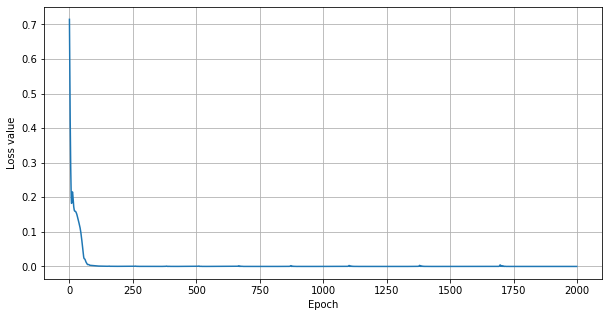

In [23]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [27]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=ResnetSolver()
    ) 

In [28]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [29]:
mse_loss(x_pred_validate, x_validate) 

tensor(0.0293, dtype=torch.float64)

In [30]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [31]:
def plot_predictions(n=0):

    print("Validation", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, n, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validation 0


<ipython-input-31-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-31-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-31-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

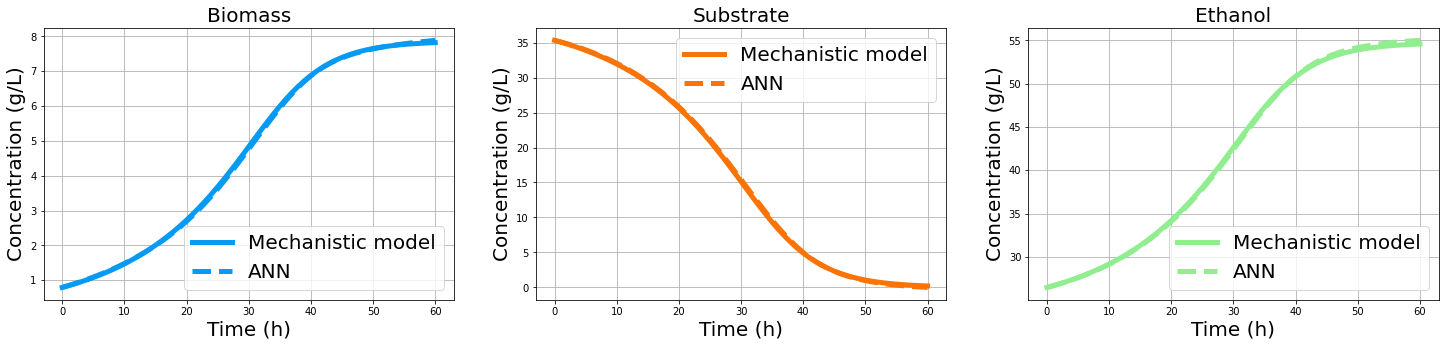

Validation 1


<ipython-input-31-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-31-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-31-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

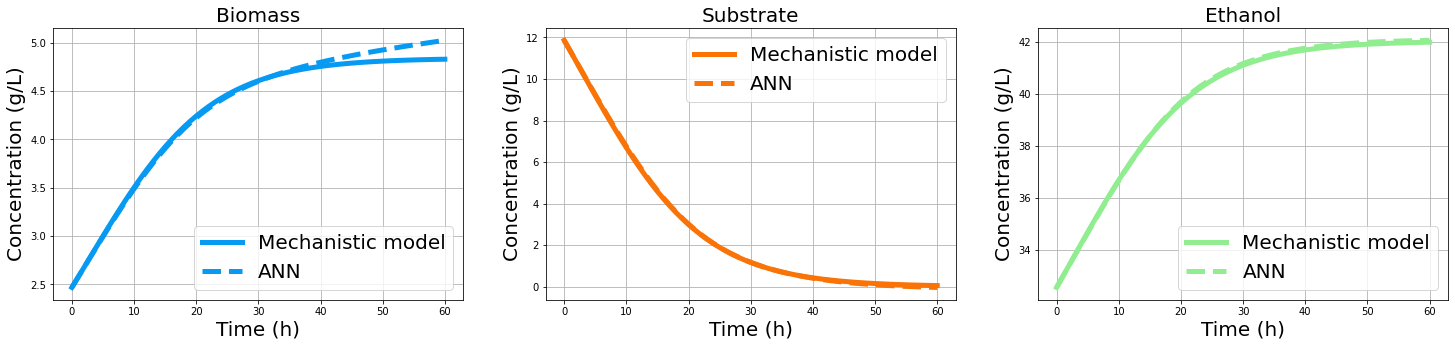

Validation 2


<ipython-input-31-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-31-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-31-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

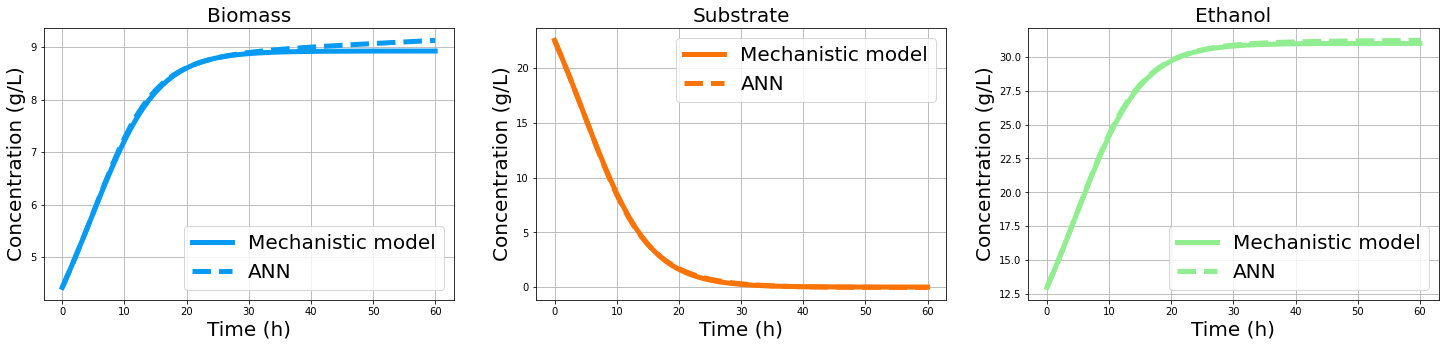

Validation 3


<ipython-input-31-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-31-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-31-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

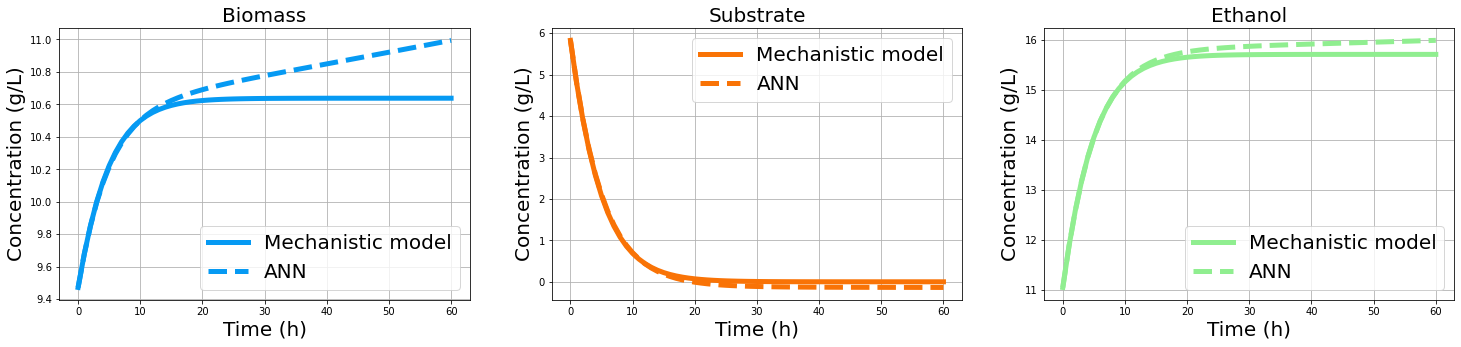

Validation 4


<ipython-input-31-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-31-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-31-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

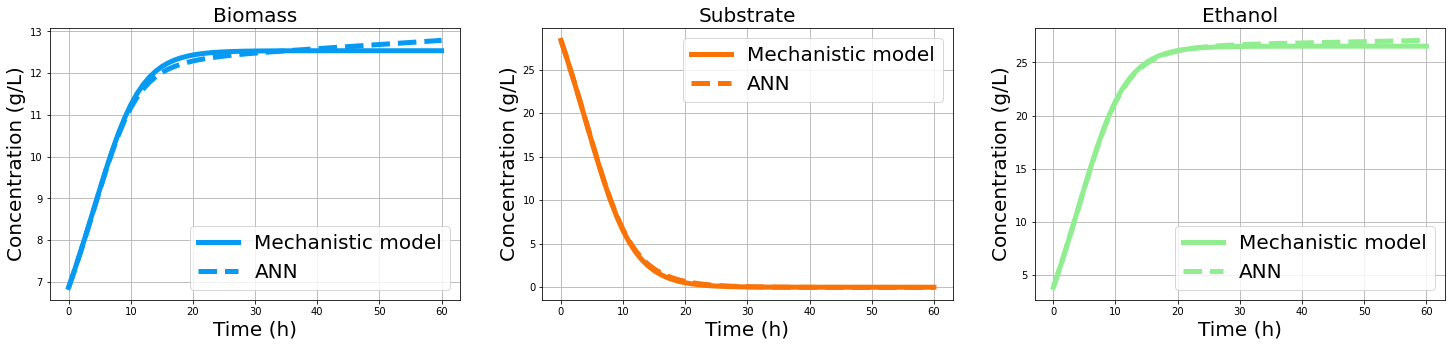

In [32]:
for i in range(5):
    plot_predictions(i)